**Analysis of cluster algorithms for Monte Carlo methods applied to the Ising model**
=================================================================================
This report explores the efficiency and performance of cluster algorithms for Markov Chain Monte Carlo (MCMC) methods specifically for the case of the Ising model. In particular, the Wolff algorithm is implemented, analysed and compared to the Metropolis-Hastings (MH) algorithm. The performance of these algorithms is studied near criticality, exploring autocorrelation times and the phenomenon of critical slowing down. **ETC**

## 1.  Introduction

Monte Carlo methods have been around since the 18th Century (Buffon's Needle Problem) but they were first applied to physical systems in the late 1940s within the Manhattan Project **[REFERENCE Ulam, Von Neumann]** to neutron diffusion in nuclear fission. They were extensively developed throughout the second half of the 20th century by the likes of Metropolis **[REFERENCE 1953]** and Hastings **[REFERENCE 1970]** with the Metropolis-Hastings Algorithm (originally referred to as the Metropolis Algorithm before Hastings generalised from symmetric to general proposcal distributions) one of the first techniques used to approximate distributions and integrals. Monte Carlo methods are applied frequently in statistical mechanics, specifically for thermodynamic systems like the Ising model which will be used in this report. 
    
The aforementioned Metropolis-Hastings (MH) algorithm (and the Glauber algorithm **[REFERENCE GLAUBER]**) uses local updates when proposing transitions in order to have efficient acceptance rates. However, in models with second order phase transitions, like the ferromagnetic case of the Ising model, these methods run into the problem of large autocorrelation times and the phenomenon of critical slowing down near criticality. This can be explained by considering the scale invariance of the system at the critical temperature (see section **REFERENCE**).

Cluster algorithms were formulated as a solution to this problem; they use non local updates to explore the state space more quickly and take advantage of updating multiple sites (flipping multiple spins in the context of the Ising model) to decorrelate system measurements and produce independent states faster (see` section **REFERENCE**)

This report aims to build on the body of work surrounding these algorithms in the specific case of the 2D Ising model, chosen due to the ability to compare numerical with analytical results. Specifically, the Wolff algorithm **[REFERENCE]** will be described and analysed considering the *detailed balance condition* followed by computational study of its performance and efficieny compared to the MH algorithm by studying autocorrleation times near criticality and comparing the algorithms' dynamic exponents. The code is writted that allows for changes in the size, $N$, of the lattice.

## 2. Theoretical Background

### 2.1. The 2D Ising model

The 2D Ising model consists of a $L \times L$ lattice of size $N = L^{2}$ where on each vertex, $i$, of the lattice, there is a one-component type spin, $s_i$ that can take the values $s_i = \pm 1$ giving the configuration $s \equiv \{s_i\}$. In the ferromagnetic case with no external field, $J > 0$, and the Hamiltonian, $\mathcal{H}$, of the system is given by:

$$
\mathcal{H} = - J \sum_{i,\delta}s_is_{i+\delta}\tag{1}$$

Where the sum runs over all sites on the lattice, $i$, and the $\delta$ sum runs over the nearest neighbours. The configuration probability, $p(s)$, and canonical partition function, $Z$, at inverse temperature $\beta=\frac{1}{k_{B}T}$ are given by:

$$p(s) = \frac{1}{Z} e^{-\beta H(\{s_i\})}, \qquad Z = \sum_{\{s_i\}} e^{-\beta H(\{s_i\})}.\tag{2,3}$$

With $s \equiv \{s_i\} \in \{-1,1\}^N.$ The sum runs over all spin configurations $\{s_i\}$. One of the most important variables of the system is the overall relative magnetisation of the complete lattice and the corresponding expected total magnetisation

$$M = \frac{1}{N}\sum_i^N s_i, \qquad \mathbb{E}[M]=\sum_{s}M(s)p(s).\tag{4,5}$$

The expectation value of any observable can be computed in the same way. For the case of no external field, an analytic solution for the mean total magnetisation was discovered by Lars Onsager **[REFERENCE]** 

$$
\langle M \rangle = \begin{cases}0 & \text {if } T \geq T_c \\ 
\pm \left(1-\sinh \left(2 \beta J\right)^{-4}\right)^{\frac{1}{8}} & \text {if } T<T_c\end{cases}\tag{6}
$$
The critical temperature $T_c=\frac{2 J}{k_b \ln (1+\sqrt{2})}$ determines where the phase transition occurs. Since the mean magnetisation continuosly characterises the phase transition **(see figure X)** it is a suitable order parameter for the transition.

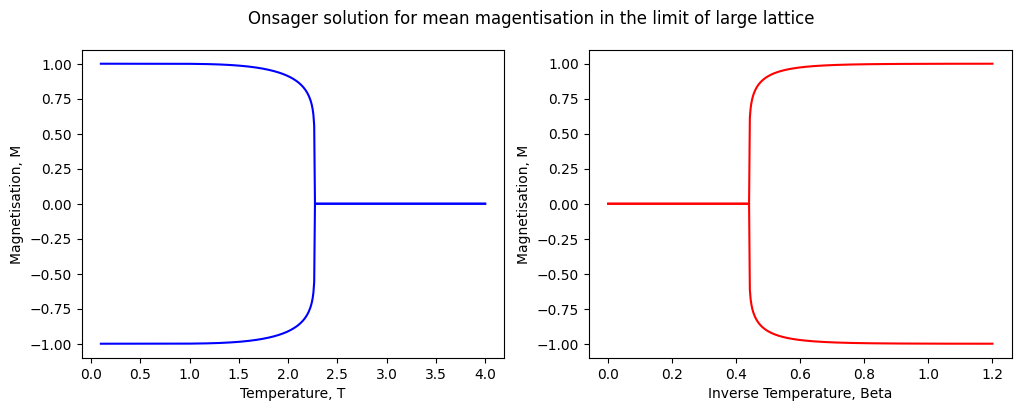

In [2]:
%run onsager #plots the analytic solution for mean magnetisation given above

Near criticality, that is: near $t = \frac{T}{T_c}-1 \ll 1$ (or $T \approx T_c$), expressions for observables such as the mean magnetisation, susceptibilty, $\chi$, and correlation length, $\xi$, obtained from a mean field theory approach can be expanded around $t = 0$ and the physical quantities can be expressed as critical exponents of $t$. These are universal values and characterize the singular properties of the physical quantities. The scale invariance of the system near criticality is clearly displayed as the quantities do not depend on specific parameters of the model or lattice. The critical exponents used in this report are $\nu$ and $\beta$ defined as

$$ \xi \propto |T-T_c|^{-\nu}, \qquad \langle M \rangle \propto \pm|T-T_c|^\beta\tag{7,8}.$$

Mean field theory results for the 2D Ising model predict $\nu = 1$ and $\beta = 1/8$ **[REFERENCE]**. It is important to note here the significance of the correlation length to both the mean field theory approch and the computational aspects of MCMC methods. The correlation length is the characteristic length scale at which mean properties of the system become independent from the individual components, that is, the length at which correlations decrease significantly. Above the critical temperature, this gives an indication of the maximum size of clusters of correlated spins. As $T$ approaches $T_c$, $\xi$ starts to diverge and clusters of all sizes start to appear, essentially, correlations and fluctuations on all scales become equally important and this has significant impacts on the computational aspects of this system (see section **[REFERENCE]**).

### 2.2. Algorithms

Monte Carlo Markov Chain processes are suitable for the Ising model. Since there can be such large variation in sample means (from $e^{-2N\beta J}/Z$ to $e^{2N\beta J}/Z$) and brute force calculations require sums over $2^N$ terms, methods that avoid calculating the partition function through ratios of probabilities are advantageous. MCMC methods evolve the Ising configuration and involve much less computational effort and only require the desired probability distribution up to a normalisation factor. 

Markov Chain algorithms (uniquely) defined by a transition probability matrix $P(x \to x')$ of a given state $x$ to any state $x'$ must satisfy two conditions in order to have unique stationary distribution $\pi(x)$ that asymptotically reaches the desired distribution $P(x)$:

1. *Detailed Balance*: a sufficient condition for the existence of a stationary distribution is the detailed balance condition, it requires that each transition is reversible, that is, the flow of probability between any two states $x$ and $x'$ is the same in both directions.
$$ \pi(x)P(x \to x') = \pi(x')P(x' \to x)\tag{9}$$

2. *Irreducible and aperiodic*: A transition matrix is irreducible if for every pair of states $x,x'$ in the state space the chance of a Markov chain connecting them is non zero. It is aperiodic if there is no set, single finite number of steps in a Markov chain separating the states. This ensures the stationary distribution is convergent, unique and independent of the initial distribution. This condition is also known as *ergodicity*.

The algorithms are outlined below and the two conditions are shown to be satisfied in each case

**Metropolis-Hastings Algorithm**

The Metropolis-Hastings algorithm splits the transition matrix into a proposal and acceptance probability $P(x \to x') = q(x \to x')A(x \to x')$ and so detailed balance is satisfied if:
$$ \frac{A(x \to x')}{A(x' \to x)} = \frac{\pi(x')q(x' \to x)}{\pi(x)q(x \to x')}$$
The choice of $A$ in the Metropolis-Hastings algorithm is:
$$ A(x \to x') = min\left(1,\frac{\pi(x')q(x' \to x)}{\pi(x)q(x \to x')}\right)$$
Which explicitly satisfies detailed balance; either $A(x \to x') = 1$ and $A(x' \to x) = \frac{\pi(x)q(x \to x')}{\pi(x')q(x' \to x)}$ or vice versa (with the primes switched) which shows that the acceptance probability is reversible.
The choice of the proposal transition matrix must be irreducible and reversible. The simplest choice, in the case of the Ising model, is to select any one site $i$ on the lattice with uniform likelihood and flip the spin. This is clearly reversible and it is irreducible and aperiodic because any other state in the state space can be reached by a succession of single spin flips.

The desired distribution is $\pi(s) = p(s) = e^{-\beta H(s)}/Z$ for $s = \{s_i\}$ and so $$A(s \to s') = min\left(1,e^{-\beta\Delta E}\right) = \begin{cases} 1 &\text{if }\Delta E \leq 0 \\ e^{-\beta\Delta E} &\text{if }\Delta E > 0 \end{cases}\tag{10}$$ where $$\Delta E = H(s') - H(s) = 2J s_i \sum_{\delta} s_{i+\delta}\tag{11}$$
with the sum over the 4 neighbours $\delta$ of $i$.

**Wolff Algorithm & Cluster Algorithms**

<!--- Cluster algorithms were introduced to reduce the phenomena of large autocorrelation times near criticality (critical slowing down) (see section **2.3**). These algortithms get around this problem by working on the basis of growing clusters from a particular seed site $i_{seed}$ and then flipping multiple spins in a non-local update, exploring the phase space more quickly. This means that even near criticality, the lattice should be decorrelated because large percolation clusters are flipped together compared to the MH case where this must happen spin by spin. Traditionally, the energy change for such a move would be very large implying a very small acceptance probability for the MH algorithm which needs small changes in energy for satisfactory acceptance rates, however most cluster algorithms are rejection free (subsequent states in the Markov chain are always different) and work by adding to the cluster with a probability $0<p_{add}<1$. -->

In the Wolff algorithm, the next state $s'$ in the chain is obtained by flipping all the spins in a randomly generated cluster $C$:
$$ s' = \begin{cases} -s_i & i \in C \\ s_i & i \notin C \end{cases} $$
$C$ is constructed iteratively from a random seed site. Neighbouring spins with the same spin value (aligned) are added to the cluster with probability $0<p_{add}<1$, with each site in the cluster visited only once. The cluster is finished when every site has been visited once.

Since there is a $(1 - p_{add})^4>0$ chance that the move is a single-flip one then the transition is irreducible (as in MH case above). The transition is also aperiodic since it is possible to return to a state in 2, 3 or more moves via single, double or multi-flip moves, that is, there is no set number of moves to return to a state.

Detailed balance can be satisfied by a specific choice of $p_{add}$:

Consider the set of possible clusters $C$, for each $C$, the only difference between the backwards and forwards transitions, $P(s \to s') \text{and } P(s' \to s)$ occurs at the boundrary of the cluster (since all spins are aligned inside by definition). Then comparing the ratios of these probabilities will lead to detailed balance. Let $m$ be the number of spins bordering $C$ in aligned states and $m$ be the number of spins bordering $C$ in anti-aligned states then:
$$
P(C \text{ selected for } s \to s') \propto (1-p_{add})^m, \quad P(C \text{ selected for } s' \to s) \propto (1-p_{add})^n\tag{12}
$$
Since in the reverse case, the cluster is flipped and $m$ and $n$ are exchanged. Putting equations (9) and (12) together along with equation (2) for the desired distribution, we arrive at the detailed baance requirement for $p_{add}$:
$$
\frac{P(s \to s')}{P(s' \to s)} = \frac{\pi(s')}{\pi(s)} = (1-p_{add})^{m-n} = e^{-\beta\Delta E}.
$$
Where, following from equation (11), $\Delta E = 2Jm - 2Jn$ and so detailed balance is satisfied for
$$ p_{add} = 1 - e^{-2\beta J}\tag{13}.$$

### 2.3. Autocorrelation and Critical Slowing Down

## 3. Implementation

### 3.1. Initial Setup

The code below imports the required libraries and defines some useful functions that are used for the rest of the report. The functions `create_lattice` and `plot_lattice` are used to create several types of initial lattice and view them respectively. Note periodic boundrary conditions have been used and as such, each site has the same number of neighbours.

Note in the analysis above and the implementation below $J$ never appears separate from $\beta$ so it is safely set to 1.

In [2]:
# Importing libraries
import numpy as np
rng = np.random.default_rng()
import matplotlib.pylab as plt

In [37]:
"""Creates a lattice and defines useful functions such as calculating neighbouring sites, 
calculating the sum of neighbouring spin sites and computes the total magnetisation of the lattice"""

def create_lattice(width,type=0):
    """Creates a lattice array of three types
    
    Type 1: all spins +1
    Type -1: all spins -1
    Type 0: a random lattice of spins +/-
    Type 2: anti-aligned lattice
    """
    lattice = np.array((width,width))   
    if type == 1:
        return np.ones((width,width))
    elif type == 0:
        return np.random.choice([1,-1],(width,width))
    elif type == -1:
        return (-1)*np.ones((width,width))
    elif type == 2:
            if width%2 == 0:
                return np.tile([[1,-1],[-1,1]],(width//2,width//2))
            else:
                return np.tile([[1,-1],[-1,1]],((width+1)//2,(width+1)//2))[:width,:width]
    else:
        raise ValueError("Invalid type. Type should be 0, 1, or -1.")

def plot_lattice(lattice,ax,title):
    """Plots the lattice with black as +1, and white as -1"""
    ax.matshow(lattice, vmin=-1, vmax=1, cmap=plt.cm.binary)
    ax.title.set_text(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])

def get_neighbouring_sites(i,j,width):
    """Returns the coordinates of the neighbouring sites of a given coordinate with periodic boundrary conditions"""
    neighbours = [((i-1)%width, j), ((i+1)%width, j), (i, (j-1)%width), (i, (j+1)%width)]
    return neighbours

def neighbouring_spins_sum(i,j,lattice,width):
    """Returns the sum of the spins of the neighbouring sites of a given coordinate (i,j)"""
    neighbours = get_neighbouring_sites(i,j,width)
    sum_neighbours = sum(lattice[i] for i in neighbours)
    return sum_neighbours

def magnetisation(lattice):
    """Computes the overall magnetisation of the lattice"""
    Mag = lattice.sum()/(len(lattice)**2)
    return Mag

### 3.2. Metropolis-Hastings Implementation

The Metropolis-Hastings algorithm described in section (**2.2**) is implemented here and equlibrated

In [83]:
"""Metropolis-Hastings algorithm"""

def compute_acceptance(i, j, lattice, width, betaJ):
    """Computes the acceptance probability from energy difference between the old and 
       new state if spin[i,j] is flipped.
    """
    betaDeltaE=2*(betaJ*lattice[i,j]*neighbouring_spins_sum(i, j, lattice, width))
    acceptance=np.exp(-1*betaDeltaE)
    return acceptance, betaDeltaE

def MH_flip(lattice, width, betaJ):
    """Proposes a new site to be flipped (proposal matrix) and accepts or rejects the flip based on MH acceptance matrix"""
    i, j = np.random.randint(0,width,2)

    acceptance, betaDeltaE=compute_acceptance(i, j, lattice, len(lattice), betaJ)

    #comparing probabilities
    if betaDeltaE <= 0 or np.random.rand() < acceptance:
        lattice[i,j] *= -1

def n_MH_moves(lattice, width, betaJ, n):
    for i in range(n):
        MH_flip(lattice, width, betaJ)
            
def compute_M_avg(lattice, width, betaJ, avg_times):
    """Evolves the lattice using the Metropolis-Hastings algorithm and returns the average 
    absolute magnetisation per site computed using different time steps.
    """
    m=[]
    for t in range(avg_times[-1]+1):
        MH_flip(lattice, width, betaJ)
        if t in avg_times:
            m.append(abs(magnetisation(lattice)))
    m_avg = np.mean(m)
    return m_avg

def evolve_and_plot(lattice, width, betaJ, plot_times):
    """Evolves the lattice using MH algorithm and plots the lattice at different 'time steps'."""
    fig, ax = plt.subplots(1, len(plot_times), figsize=(16,6))
    
    for t in range(plot_times[-1]+1):
        MH_flip(lattice, width, betaJ)
        if t in plot_times:
            plot_lattice(lattice, ax[plot_times.index(t)], "t = {}".format(t))
            ax[plot_times.index(t)].set_xlabel("sweeps = {}".format(t/width**2))
    plt.show()


The algorithm is tested for $\beta = 1.5$ and a lattice size of $N = 50^2$ by plotting the states at time intervals using the `evolve_and_plot` function and computing the average absolute magnetisation using `compute_M_avg` relying on the independence of states separated by large time intervals.

In [89]:
# Testing the Metropolis-Hastings algorithm
avg_times = [200000,250000,300000]
width = 50
type = 0
betaJ = 1.5
initial_lattice = create_lattice(width, type)
print('Average magnetisation per site = '+str(compute_M_avg(initial_lattice,width,betaJ,avg_times)))

Average magnetisation per site = 0.8847999999999999


![Alt text](images/MH_states_50_1.5.png)

Where in the figures above and below, one sweep corresponds to $N = L^2$ Metropolis-Hastings flips. That is, a sweep is approximately when every spin site has been visited once.

It clearly takes at a computationally significant number of sweeps in the Markov chain for the process to equilibrate and so the average times to compute the magnetisation have been started with a 'burn in' of 30 sweeps. The plot below considers the average magnetisation for different initial states and temperatures as a function of sweeps to explore further the equilibration time of this method.

![Alt text](images/MH_equilibration_temps.png)

This plot was generated using `MH_equilibrations.py`. It can be seen above that all initial conditions have equilibrated by $\tau_{eq} \approx 30$ sweeps for the case where the temperature is above $T_c$, however for the case below $T_c$ the anti-aligned initial state seems to strugle with equilibration.

### 3.3 Wolff Algorithm Implementation

Here, the Wolff algorithm described in section **2.2** is implemented and equilibrated.

the function `evolve_and_plot` has been redefined to include a choice between using the Metropolis-Hastings or Wolff algorithm.

In [95]:
"""Wolff Algorithm"""

from collections import deque

def wolff_flip1(lattice, p_add):
    """Grows the cluster flip by flip with parameter p_add so that it is not computed each step.
       This avoids having to store the cluster.
    """
    seed = tuple(rng.integers(0,len(lattice),2))
    
    w = len(lattice)
    
    spin = lattice[seed] # get the spin of the seed site
    lattice[seed] = -spin # flip the seed side to begin cluster
    c_size = 1 # initialize tracking of cluster size
    
    remaining_sites = deque([seed]) # track remaining unvisited cluster sites
    while remaining_sites:
        
        site = remaining_sites.pop() # remove from the remaining list
        i, j = site[0], site[1]
        
        for n in get_neighbouring_sites(i,j,w):
            
            if lattice[n] == spin and rng.uniform() < p_add:
                lattice[n] = -spin
                remaining_sites.appendleft(n)
                c_size += 1 # track cluster size
    return c_size

def n_wolff_moves(lattice, p_add, n):
    """executes n Wolff moves/flips"""
    total_flips = 0
    for i in range(n):
        total_flips += wolff_flip1(lattice,p_add)
    return total_flips

def compute_M_avg_wolff(lattice, p_add, avg_times):
    """Evolves the lattice using the Wolff algorithm and returns the average 
    absolute magnetisation per site computed using different time steps.
    """
    m=[]
    for t in range(avg_times[-1]+1):
        wolff_flip1(lattice, p_add)
        if t in avg_times:
            m.append(abs(magnetisation(lattice)))
    m_avg = np.mean(m)
    return m_avg

#########################################################################################################################

# REDEFINING EVOLVE AND PLOT FUNCTION FOR CHOICE OF BOTH ALGORITHMS
def evolve_and_plot(lattice, betaJ, p_add, plot_times, wolff=True):
    """Evolves the lattice using MH or Wolff algorithm and plots the lattice at different 'time steps'."""
    fig, ax = plt.subplots(1, len(plot_times), figsize=(12,4))
    
    if wolff == True:
        for t in range(plot_times[-1]+1):
            c_size += wolff_flip1(lattice, p_add)
            if t in plot_times:
                plot_lattice(lattice, ax[plot_times.index(t)], "t = {}".format(t))
    else:    
        for t in range(plot_times[-1]+1):
            MH_flip(lattice, len(lattice), betaJ)
            if t in plot_times:
                plot_lattice(lattice, ax[plot_times.index(t)], "t = {}".format(t))
    plt.show()

As with the Metropolis case. The Wolff algorithm is tested for $\beta = 0.44$ close to $T_c$ and a lattice size of $N = 100^2$ by plotting the states at time intervals using the new `evolve_and_plot` function. The average absolute magnetisation was computed using `compute_M_avg_wolff` for $\beta = 1.5$ and a lattice size of $N = 50^2$.

In [99]:
# Testing the Metropolis-Hastings algorithm
avg_times = [50000,60000,70000]
width = 20
type = 0
betaJ = 1.5
p_add = 1-np.exp(-2*betaJ)
initial_lattice = create_lattice(width, type)
print('Average magnetisation per site = '+str(compute_M_avg_wolff(initial_lattice, p_add, avg_times=avg_times)))

Average magnetisation per site = 1.0


![Alt text](images/wolff_states_100_0.44.png)

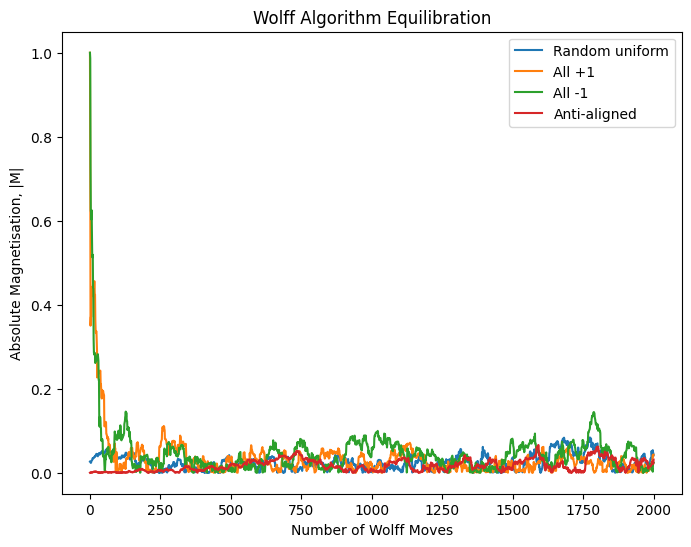

In [26]:
def plot_equilibration_wolff(betaJ, n_iterations):
    p_add = 1 - np.exp(-2*betaJ)

    fig, ax = plt.subplots(figsize=(8, 6))

    lattice_types = [(0, "Random uniform"), (1, "All +1"), (-1, "All -1"), (2, "Anti-aligned")]
    for i, (lattice_type, name) in enumerate(lattice_types):
        lattice = create_lattice(64, type=lattice_type)

        # Measurement stage
        mag = np.abs(magnetisation(lattice))
        magnetisations = [mag]
        for _ in range(n_iterations):
            n_wolff_moves(lattice, p_add, 1)
            mag = np.abs(magnetisation(lattice))
            magnetisations.append(mag)

        ax.plot(magnetisations, label=name)

    ax.set_xlabel("Number of Wolff Moves")
    ax.set_ylabel("Absolute Magnetisation, |M|")
    ax.set_title("Wolff Algorithm Equilibration")
    ax.legend()
    plt.show()

plot_equilibration_wolff(0.3,2000)

In [ ]:
width = 40
N = width**2
temps = np.linspace(1.5,3.5,20)
burn_in = 500
n_moves = 5000

cluster_sizes = []

for temp in temps:
    p_add = 1 - np.exp(-2/temp)
    lattice = create_lattice(width, 0)
    n_wolff_moves(lattice, p_add, burn_in)
    total_flips = 0
    for i in range(n_moves):
        total_flips += n_wolff_moves(lattice,p_add,1)
    cluster_sizes.append(total_flips/(n_moves))

fig, ax = plt.subplots()
ax.plot(temps,cluster_sizes)
ax.set_xlabel("T")
ax.set_ylabel("Average Cluster Size")
plt.show()

### 3.4 Comparing solutions

`MH_onsager.py` and `wolff_onsager.py` have been used to compare the respective algorithm's solution with the analytical Onsager solution. Below are the two plots:
<p float="left">
  <img src="images\MH_onsager.png" width="480" />
  <img src="images\MH_onsager.png" width="480" /> 
</p>

### 3.5 Autocorrelation and Critical Slowing down

In [7]:
def autocorrelation(data,t_max):
    """Computes ACF for a given time series"""
    size = len(data)
    mean = np.mean(data)
    var = np.var(data)

    # autocovariance
    autocov = np.zeros(size)
    for t in range(t_max):
        autocov[t] = np.dot(data[:size-t] - mean, data[t:] - mean) / (size)

    #normalise
    autocorr = autocov/var

    return autocorr

def autocorrelation_time(data, tmax):
    """Finds the autocorrelation time of a given data series"""
    autocorr = autocorrelation(data, tmax)
    crit = np.exp(-1)
    autocorr_times = np.where(autocorr < crit)
    # if the length of autocorr_times is 0 then there are no values below 1/e so return len(autocorr)
    return autocorr_times[0][0] if len(autocorr_times[0]) > 0 else len(autocorr)    

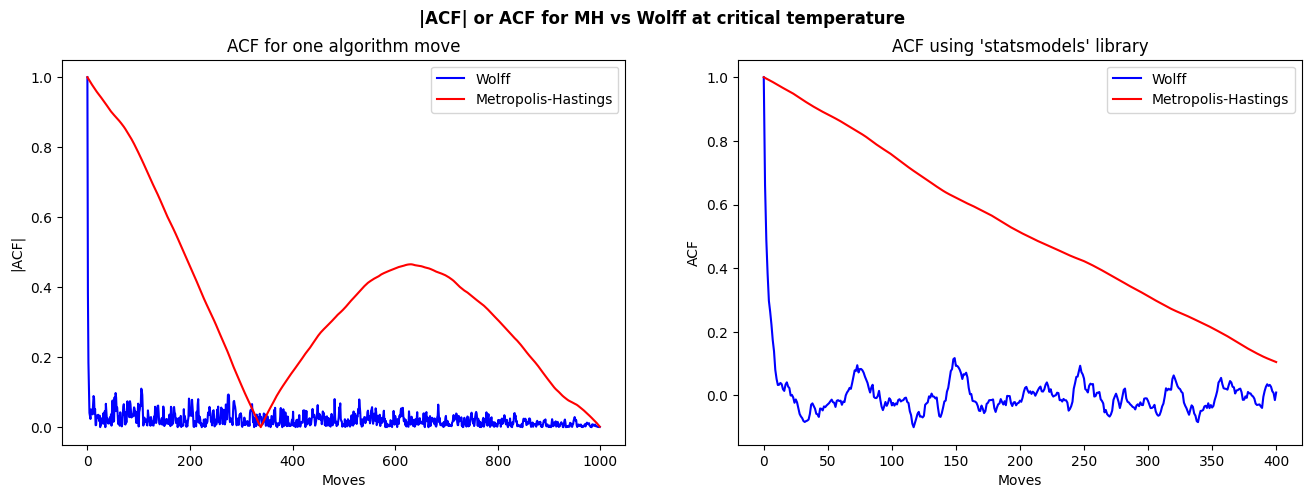

In [15]:
"""Plotting data for the autocorrelation function, using different sampling methods and ways of calculating ACF.
   Loads data from files generated by acf.py, acf2.py, and acf_accountforcluster.py
"""

#data_account = np.load('acf_accountforsweeps.npy', allow_pickle=True)
data_same = np.load('acf_samemoves.npy', allow_pickle=True)
data_same2 = np.load('acf_samemoves2.npy', allow_pickle=True)

#ACF_MH_account = data_account[0]
#ACF_wolff_account = data_account[1]

ACF_MH_same = data_same[0]
ACF_wolff_same = data_same[1]

ACF_MH_same2 = data_same2[0]
ACF_wolff_same2 = data_same2[1]

fig, ax = plt.subplots(1,2,figsize = (16,5))
fig.suptitle(r'|ACF| or ACF for MH vs Wolff at critical temperature', fontweight='bold')
ax[0].plot(ACF_wolff_same, label='Wolff', color='blue')
ax[0].plot(ACF_MH_same, label='Metropolis-Hastings', color='red')
ax[1].plot(ACF_wolff_same2, label='Wolff', color='blue')
ax[1].plot(ACF_MH_same2, label='Metropolis-Hastings', color='red')
ax[0].set_xlabel('Moves')
ax[0].set_ylabel('|ACF|')
ax[1].set_xlabel('Moves')
ax[1].set_ylabel('ACF')
ax[0].set_title('ACF for one algorithm move')
ax[1].set_title("ACF using 'statsmodels' library")
ax[0].legend()
ax[1].legend()
plt.show()

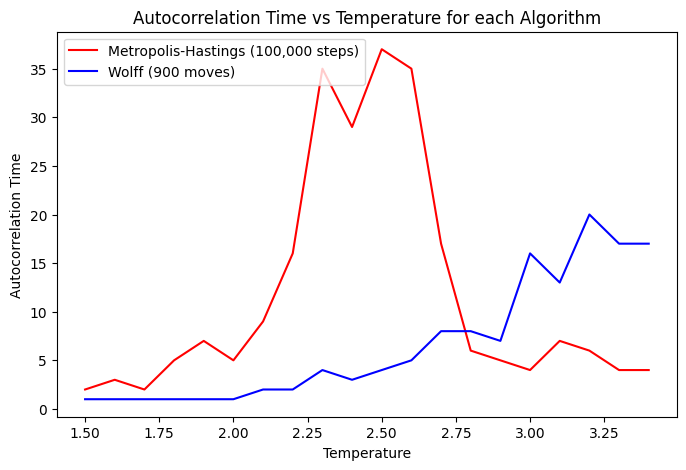

In [100]:
"""MORE DATA REQUIRED FOR HIGHER TEMPERATURES"""

wadata = np.load('wolff_autocorrelation_data.npy')
mhadata = np.load('MH_autocorrelation_data.npy')

plt.figure(figsize=(8,5))
plt.plot(mhadata[0], mhadata[1], label='Metropolis-Hastings (100,000 steps)', color='red')
plt.plot(wadata[0], wadata[1], label='Wolff (900 moves)', color='blue')
plt.xlabel('Temperature')
plt.ylabel('Autocorrelation Time')
plt.title('Autocorrelation Time vs Temperature for each Algorithm')
plt.legend(loc='upper left')
plt.show()